## Artificial Intelligence for Health analytics

Changhyun Kim (ID: 21134342)

### Preparing datasets

loading training, development, and test datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("features/train.csv",sep=';')
train_data = train_data.drop(['name', 'frameTime'], axis=1)

devel_data = pd.read_csv("features/devel.csv",sep=';')
devel_data = devel_data.drop(['name', 'frameTime'], axis=1)

test_data = pd.read_csv("features/test.csv",sep=';')
test_data = test_data.drop(['name', 'frameTime'], axis=1)

In [3]:
X_train = np.asarray(train_data.values)
X_devel = np.asarray(devel_data.values)
X_test = np.asarray(test_data.values)

print(X_train.shape)
print(X_devel.shape)
print(X_test.shape)

(9505, 88)
(9596, 88)
(9551, 88)


In [4]:
train_label = pd.read_csv('labels/train.csv')
train_label = train_label.drop(['file_name'], axis=1)

devel_label = pd.read_csv('labels/devel.csv')
devel_label = devel_label.drop(['file_name'], axis=1)

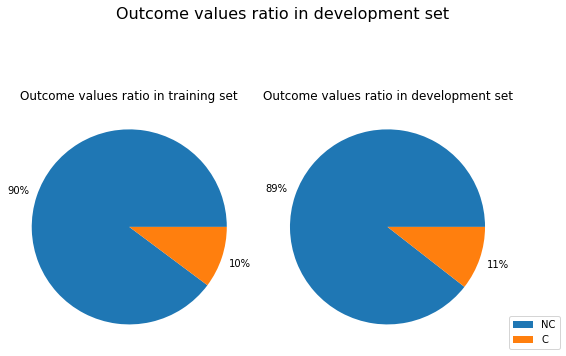

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=False, sharey=False)    
labels = ['NC', 'C']

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        x = train_label.iloc[:,0]
        title = 'Outcome values ratio in training set'
    else:
        x = devel_label.iloc[:,0]
        title = 'Outcome values ratio in development set'
    
    ax.pie(x.value_counts(),  autopct='%1.0f%%', pctdistance=1.2)
    ax.set_title(title)

plt.legend(loc=(1,0), labels=labels)
plt.suptitle(title, size=16)
plt.tight_layout();
# plt.pie(train_label['Cold (upper respiratory tract infection)'].value_counts())
# plt.title('Distributions of SepsisLabel')
# plt.legend(loc=(1,0), labels=labels)
plt.show()

In [34]:
train_label['Cold'] = train_label['Cold'].apply(lambda x: 1 if x == 'C' else 0)
devel_label['Cold'] = devel_label['Cold'].apply(lambda x: 1 if x == 'C' else 0)

In [36]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

encoder = LabelEncoder()
encoder.fit([0, 1])
y_train = encoder.transform(np.ravel(train_label))
y_devel = encoder.transform(np.ravel(devel_label))

print(encoder.classes_) # 'C' is encoded as 0 and 'NC' is encoded as 1
print(y_train.shape)
print(y_devel.shape)

[0 1]
(9505,)
(9596,)


### Define calculating performance functions

The pie charts above show the datasets are highly imbalanced which may be problematic if proper techniques are ignored and accuracy metrics is regarded as standard measurements.

To estimate the performance appropriately, the following metrics will be used:
- Accuracy
- Recall (Sensitivity)
- Precision
- ROC-AUC

In [37]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def calc_performance(y_true, y_pred):
    cm= confusion_matrix(y_true, y_pred)  

    #class_names contains the labels we would like to use. This can be ignored.
    class_names  =[0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)    
    disp.plot()
    
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('ROC-AUC:', roc_auc_score(y_true, y_pred))
    plt.show()
    
def plot_roc_curve(y_true, y_decision):
    fpr, tpr, _ = roc_curve(y_true, y_decision)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc_score(y_true, y_decision),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    

### Exploration of techniques to handle data imbalance

- Mixture of random upsampling and downsampling
- balancing class weights

In [61]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy='majority')

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_devel_scaled = minmax_scaler.transform(X_devel)

X_train_scaled_bal, y_train_bal = pipeline.fit_resample(X_train_scaled, y_train)

In [39]:
from sklearn.svm import SVC
from sklearn.utils import class_weight

class_weight_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
keys = [0, 1]
class_weight_dict = dict(zip(keys, class_weight_array))
random_seed = 20

SVC(C=0.1, class_weight={0: 0.5568248388986526, 1: 4.899484536082475},
    kernel='linear', probability=True, random_state=20)

In [62]:
underover_model = SVC(kernel='linear', C=0.1, probability=True, random_state = random_seed)
underover_model.fit(X_train_scaled_bal, y_train_bal)
y_pred_underover = underover_model.predict(X_devel_scaled)
y_pred_underover_prob = underover_model.predict_proba(X_devel_scaled)

class_bal_model = SVC(kernel='linear', C=0.1, probability=True, class_weight=class_weight_dict, random_state=random_seed)
class_bal_model.fit(X_train_scaled, y_train)
y_pred_weight = class_bal_model.predict(X_devel_scaled)
y_pred_weight_prob = class_bal_model.predict_proba(X_devel_scaled)

--------Random over-undersampling-----------
Accuracy: 0.6523551479783243
Recall: 0.5806132542037586
Precision: 0.16776221777650757
ROC-AUC: 0.6207084908176627


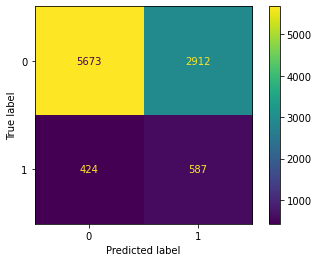

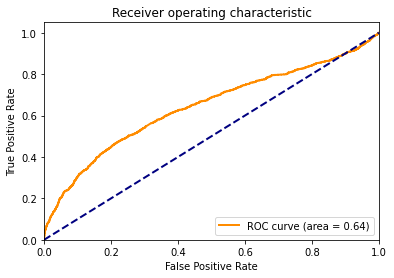

--------Balanced class weights--------------
Accuracy: 0.6641308878699458
Recall: 0.5519287833827893
Precision: 0.16766826923076922
ROC-AUC: 0.6146364941957627


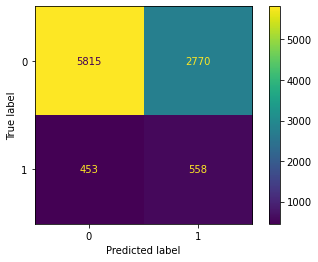

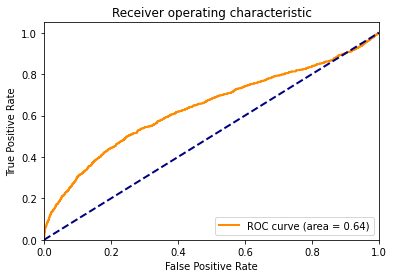

In [63]:
print('--------Random over-undersampling-----------')
calc_performance(y_devel, y_pred_underover)
plot_roc_curve(y_devel, y_pred_underover_prob[:,1])

print('--------Balanced class weights--------------')
calc_performance(y_devel, y_pred_weight)
plot_roc_curve(y_devel, y_pred_weight_prob[:,1])

There were no large difference or performance between both techniques. In this case, it can be concluded as cost-sensitive training is more efficient than the other due to it requires less memory. Balancing the number of outcome labels may not be helpful if it does not show remarkable improvement

In [64]:
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

grid = {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1]}

gridcv = GridSearchCV(SVC(class_weight=class_weight_dict, probability = True), param_grid=grid, cv=5)

gridcv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=SVC(class_weight={0: 0.5568248388986526,
                                         1: 4.899484536082475},
                           probability=True),
             param_grid={'C': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']})

Accuracy: 0.7349937473947478
Recall: 0.5469831849653808
Precision: 0.20962850644427597
ROC-AUC: 0.6520588609742454


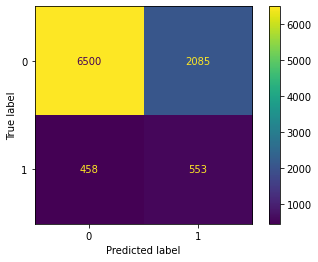

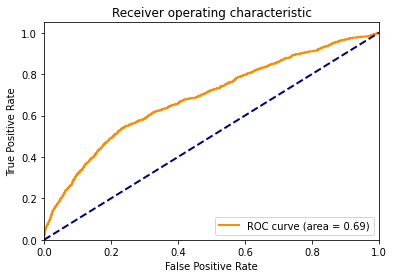

In [65]:
y_pred = gridcv.predict(X_devel_scaled)
y_pred_prob = gridcv.predict_proba(X_devel_scaled)

calc_performance(y_devel, y_pred)
plot_roc_curve(y_devel, y_pred_prob[:,1])

baseline_model = gridcv.best_estimator_

### Task2 Neural Network Classification



In [67]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler

In [68]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [69]:
y_train_vec = to_categorical(y_train, 2)
y_devel_vec = to_categorical(y_devel, 2)

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_devel_scaled = scaler.transform(X_devel)